In [1]:
print("created by: \u0930\u094b\u0936\u0928\u0940 \u0917\u094c\u095c")

created by: रोशनी गौड़


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
# Load dataset
data = pd.read_csv("wdbc.data", header=None)
#0 non cancer 
# Assign column names
num_features = data.shape[1] - 2
columns = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(1, num_features + 1)]
data.columns = columns

# Map diagnosis to binary
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

In [88]:
# Features and labels
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data: benign for training
X_benign = X_scaled[y == 0]
X_malignant = X_scaled[y == 1]

# Train/Validation split only on benign
X_train, X_val = train_test_split(X_benign, test_size=0.2, random_state=42)

In [90]:
# Create test set: benign + malignant
X_test = np.concatenate([X_benign, X_malignant])
y_test = np.concatenate([np.zeros(len(X_benign)), np.ones(len(X_malignant))])
#

input_dim = X_train.shape[1]  # 30 features
latent_dim = 10  # size of latent space

In [94]:
#Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)

#Bottle-neck
latent = Dense(latent_dim, activation='relu')(encoded)

#Decoder
decoded = Dense(32, activation='relu')(latent)
decoded = Dropout(0.2)(decoded)
decoded = Dense(64, activation='relu')(decoded)

output_layer = Dense(input_dim, activation='linear')(decoded)

#Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,808 (34.41 KB)

 Trainable params: 8,808 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Train autoencoder
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.7032 - val_loss: 0.6898
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6436 - val_loss: 0.6119
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5670 - val_loss: 0.5405
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5144 - val_loss: 0.5077
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4804 - val_loss: 0.4788
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4426 - val_loss: 0.4459
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4077 - val_loss: 0.4212
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3853 - val_loss: 0.4017
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3549 - val_loss: 0.3890
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3482 - val_loss: 0.3683
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3281 - val_loss: 0.3544
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3143 - val_lo

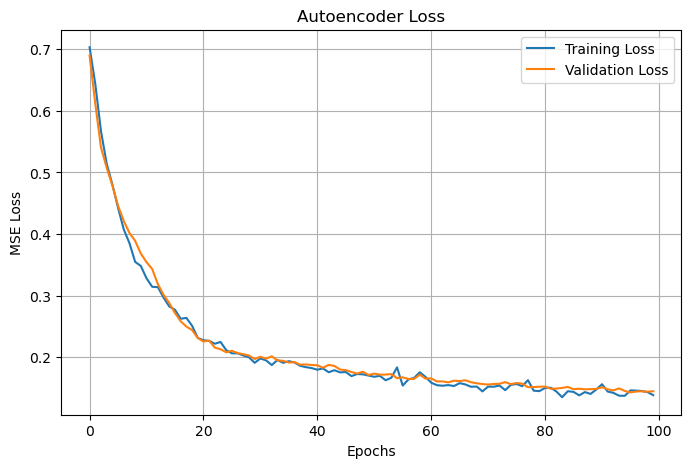

In [112]:
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Reconstruction error threshold: 0.1674
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


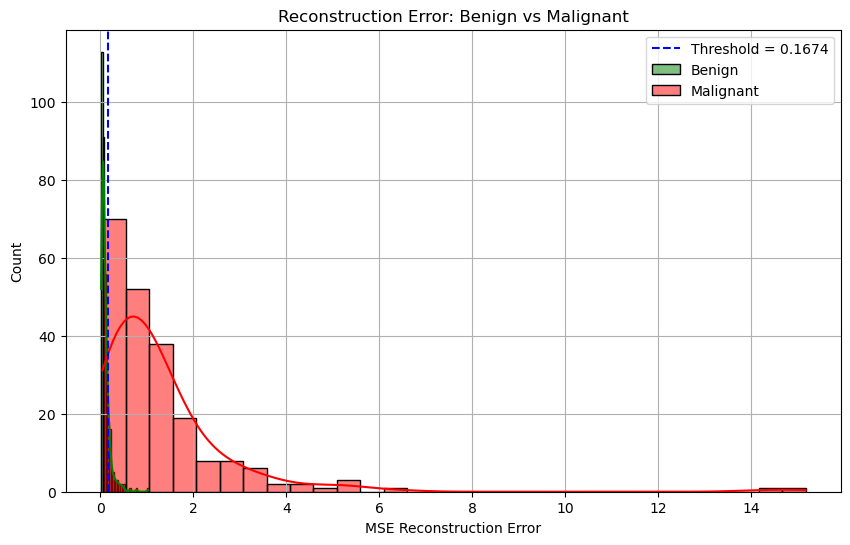

In [113]:
# Compute reconstruction errors for training benign data
X_train_pred = autoencoder.predict(X_train)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# Threshold at 95th percentile
threshold = np.percentile(mse_train, 90)
print(f"Reconstruction error threshold: {threshold:.4f}")

# Compute reconstruction error on test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Split reconstruction errors by class
reconstruction_error_benign = reconstruction_error[y_test == 0]
reconstruction_error_malignant = reconstruction_error[y_test == 1]

# Plot error distribution
plt.figure(figsize=(10,6))
sns.histplot(reconstruction_error_benign, bins=30, color='green', label='Benign', kde=True)
sns.histplot(reconstruction_error_malignant, bins=30, color='red', label='Malignant', kde=True)
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title("Reconstruction Error: Benign vs Malignant")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
 [[307  50]
 [ 13 199]]


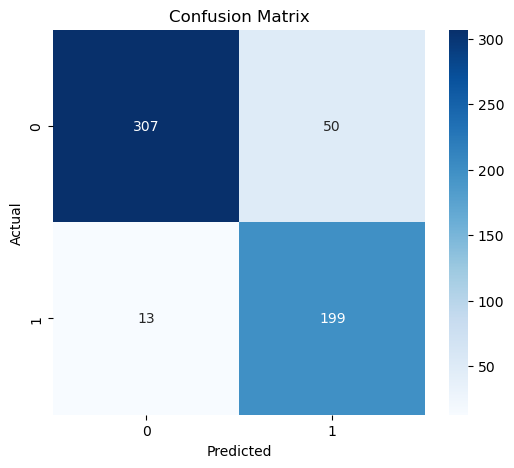


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       357
         1.0       0.80      0.94      0.86       212

    accuracy                           0.89       569
   macro avg       0.88      0.90      0.89       569
weighted avg       0.90      0.89      0.89       569



In [115]:
# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

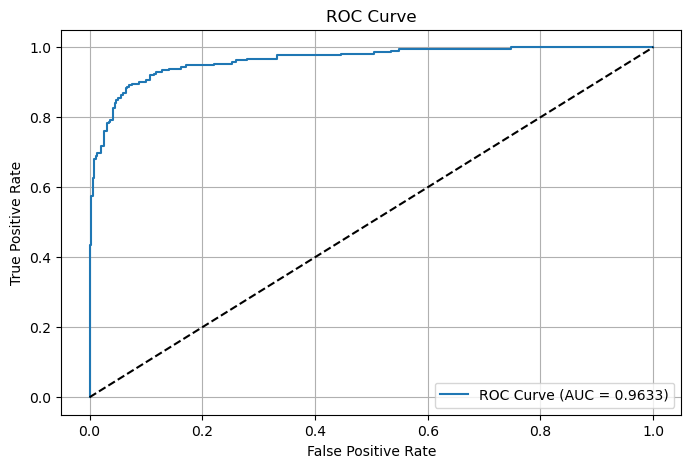

In [116]:
# ROC Curve Receiver Operating Characteristic diagnostic capability of bin classifier
fpr, tpr, _ = roc_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()